In [1]:
# based on clonealign framework, re-write with pyro
import os
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
import scipy.stats
from torch.distributions import constraints
from torch.nn import Softplus
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.5.1')
pyro.enable_validation(True)

In [2]:
# input data
patient_id = 'SPECTRUM-OV-022'
expr_csv = pd.read_csv('data/' + patient_id + '_expr_example.csv', header = 0, index_col=0)
cnv_csv = pd.read_csv('data/' + patient_id + '_cnv_example.csv', header = 0, index_col=0)

# cast cnv greater than 6
cnv = torch.tensor(cnv_csv.values, dtype=torch.float)
cnv = torch.transpose(cnv, 0, 1)

cnv[cnv > 6] = 6

expr = torch.tensor(expr_csv.values, dtype = torch.float)
expr = torch.transpose(expr, 0, 1)

In [3]:
# input data: cnv, expr
# cnv: clone_count * gene_count
# expr: cell_count * gene_count
def inverse_softplus(x):
    return x + torch.log(-torch.expm1(-x))

@config_enumerate
def clonealign_pyro(cnv, expr):
    num_of_clones = len(cnv)
    num_of_cells = len(expr)
    num_of_genes = len(expr[0])
    
    softplus = Softplus()

    # initialize per_copy_expr using the data (This typically speeds up convergence)
    per_copy_expr_guess = torch.mean(expr/torch.reshape(torch.sum(expr, 1), (num_of_cells, 1)), 0)
    
    # draw chi from gamma
    chi = pyro.sample('chi', dist.Gamma(torch.ones(6) * 2, torch.ones(6)).to_event(1))
    
    with pyro.plate('gene', num_of_genes):
        # draw per_copy_expr from softplus-transformed Normal distribution
        per_copy_expr = pyro.sample('per_copy_expr', dist.Normal(inverse_softplus(per_copy_expr_guess), torch.ones(num_of_genes)))
        per_copy_expr = softplus(per_copy_expr) 
        
        # draw w from Normal
        w = pyro.sample('w', dist.Normal(torch.zeros(6), torch.sqrt(chi)).to_event(1))
        
    
    with pyro.plate('cell', num_of_cells):
        # draw clone_assign_prob from Dir
        clone_assign_prob = pyro.sample('clone_assign_prob', dist.Dirichlet(torch.ones(num_of_clones)))
        # draw clone_assign from Cat
        clone_assign = pyro.sample('clone_assign', dist.Categorical(clone_assign_prob))
        
        # draw psi from Normal
        psi = pyro.sample('psi', dist.Normal(torch.zeros(6), torch.ones(6)).to_event(1))
        
        # construct expected_expr
        expected_expr = per_copy_expr * Vindex(cnv)[clone_assign] * torch.exp(torch.matmul(psi, torch.transpose(w, 0, 1)))
        
        # draw expr from Multinomial
        pyro.sample('obs', dist.Multinomial(probs = expected_expr, validate_args=False), obs = expr)

In [4]:
# initialize Adam optimizer
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})

# TraceEnum_ELBO will marginalize out the assignments of datapoints to clusters
elbo = TraceEnum_ELBO(max_plate_nesting=1)

pyro.clear_param_store()

# AutoGuide
global_guide = AutoDelta(poutine.block(clonealign_pyro, \
                                       expose = ['chi', 'per_copy_expr', 'w', \
                                                 'clone_assign_prob', 'psi']))
# put together SVI object
svi = SVI(clonealign_pyro, global_guide, optim, loss=elbo)

In [5]:
gradient_norms = defaultdict(list)
svi.loss(clonealign_pyro, global_guide, cnv, expr)  # Initializes param store.

13678895.0

In [6]:
losses = []
max_iter = 200
rel_tol = 1e-5
print('Start Inference.')
for i in range(max_iter if not smoke_test else 2):
    loss = svi.step(cnv, expr)
    
    if i >= 1:
        loss_diff = abs((losses[-1] - loss)/losses[-1])
        if loss_diff < rel_tol:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    
    print('.' if i % 200 else '\n', end='')

Start Inference.

.................................................................ELBO converged at iteration 66


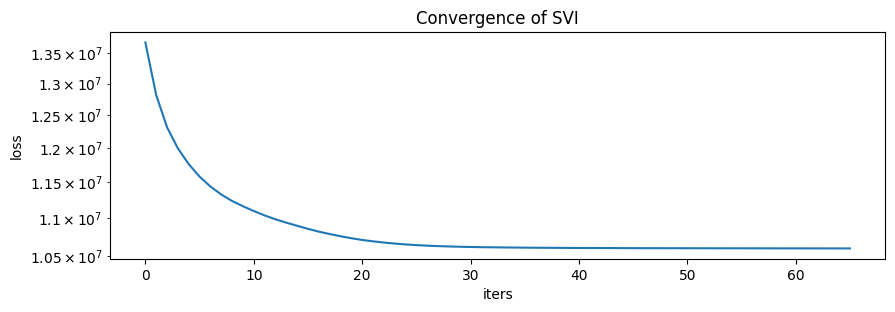

In [7]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [8]:
map_estimates = global_guide(cnv, expr)

clone_assign_prob = map_estimates['clone_assign_prob']

print('clone_assign_prob = {}'.format(clone_assign_prob.data.numpy()))

clone_assign_prob = [[0.0065985  0.0065985  0.0065985  0.9802045 ]
 [0.9802045  0.0065985  0.0065985  0.0065985 ]
 [0.98020715 0.00659622 0.00659831 0.00659834]
 ...
 [0.0065985  0.0065985  0.0065985  0.9802045 ]
 [0.00659482 0.00659687 0.9802114  0.00659687]
 [0.9802045  0.0065985  0.0065985  0.0065985 ]]


In [21]:
clone_assign_prob_dataframe = pd.DataFrame(clone_assign_prob.data.numpy())

In [23]:
cnv_csv
colname_dict = {i:c for i, c in enumerate(cnv_csv.columns)}
colname_dict

{0: 'clone1', 1: 'clone2', 2: 'clone3', 3: 'clone4'}

In [24]:
rowname_dict = {i:c for i, c in enumerate(expr_csv.columns)}
colname_dict = {i:c for i, c in enumerate(cnv_csv.columns)}

clone_assign_prob_dataframe.rename(index = rowname_dict, inplace = True)
clone_assign_prob_dataframe.rename(columns = colname_dict, inplace = True)
clone_assign_prob_dataframe

,clone1,clone2,clone3,clone4
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCACAAGCGCAA,0.006599,0.006599,0.006599,0.980205
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACCCATCGCGGACT,0.980205,0.006599,0.006599,0.006599
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGAATCCTTGGAA,0.980207,0.006596,0.006598,0.006598
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTCACTATCGA,0.980205,0.006599,0.006599,0.006599
SPECTRUM.OV.022_S1_CD45N_RIGHT_ADNEXA_AAACGCTGTCGACTTA,0.980205,0.006599,0.006599,0.006599
...,...,...,...,...
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGATCGTTCAAGTC,0.006599,0.006599,0.006599,0.980205
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGGTGTGTGTT,0.008661,0.006813,0.977715,0.006811
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGGAGTCCATTGCC,0.006599,0.006599,0.006599,0.980205
SPECTRUM.OV.022_S1_CD45N_LEFT_ADNEXA_TTTGTTGGTGTCTAAC,0.006595,0.006597,0.980211,0.006597


In [ ]:
clone_assign_prob_dataframe.to_csv("data/" + patient_id + "_clonealign_improve_clone_freq.csv")